## **Exploratory Data Analysis**

This notebook serves as a prerequisite for modelling part of the project, we want to explore the relationships between attributes as well as data distributions  
and uncover what kind of data are we dealing with.

NOTE: Production-level visualizations will be iteratively developed after the drafts, this file serves as a draft of ideas for EDA.

In [3]:
import os
import sys

sys.dont_write_bytecode = True

import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

load_dotenv()
sns.set_theme()

loading data

In [5]:
DATA_DIR = './Data/'
FILE = 'spotify_tracks_kaggle_weekly.csv'

In [6]:
data = pd.read_csv(DATA_DIR + FILE)

#### Popularity & Language distribution analysis

interestingly enough most of the songs are labeled with popularity = 0

<Axes: >

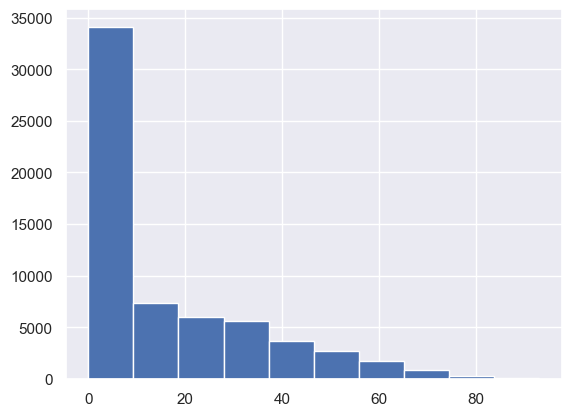

In [25]:
data['popularity'].hist()

<Axes: xlabel='language'>

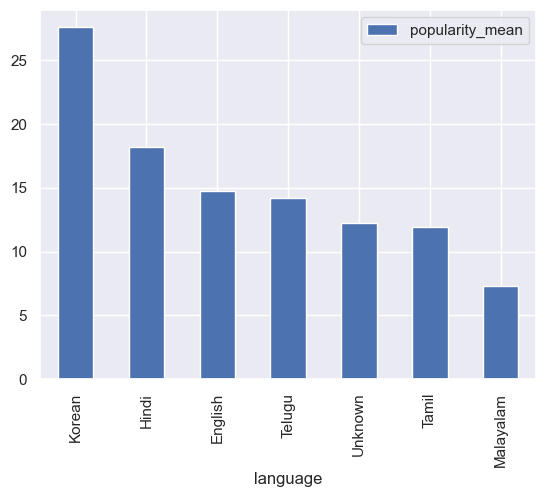

In [39]:
language_popularity = data.groupby('language').agg(
    popularity_mean = ('popularity', 'mean')
)

language_popularity.sort_values(by='popularity_mean', ascending=False).plot.bar()

Popularity across song release date - averaging aggregation

<Axes: xlabel='year'>

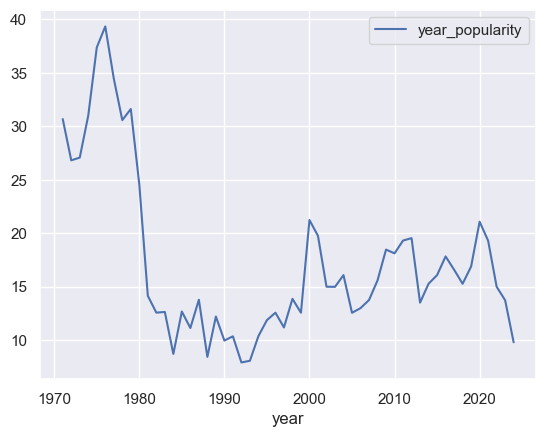

In [47]:
popularity_by_year = data.groupby('year').agg(
    year_popularity = ('popularity', 'mean')
)

popularity_by_year.plot()

we should investigate the counts bias -> we compare the counts of songs in that particular year to the popularity value to see if the popularity is not large
due to high count

c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')

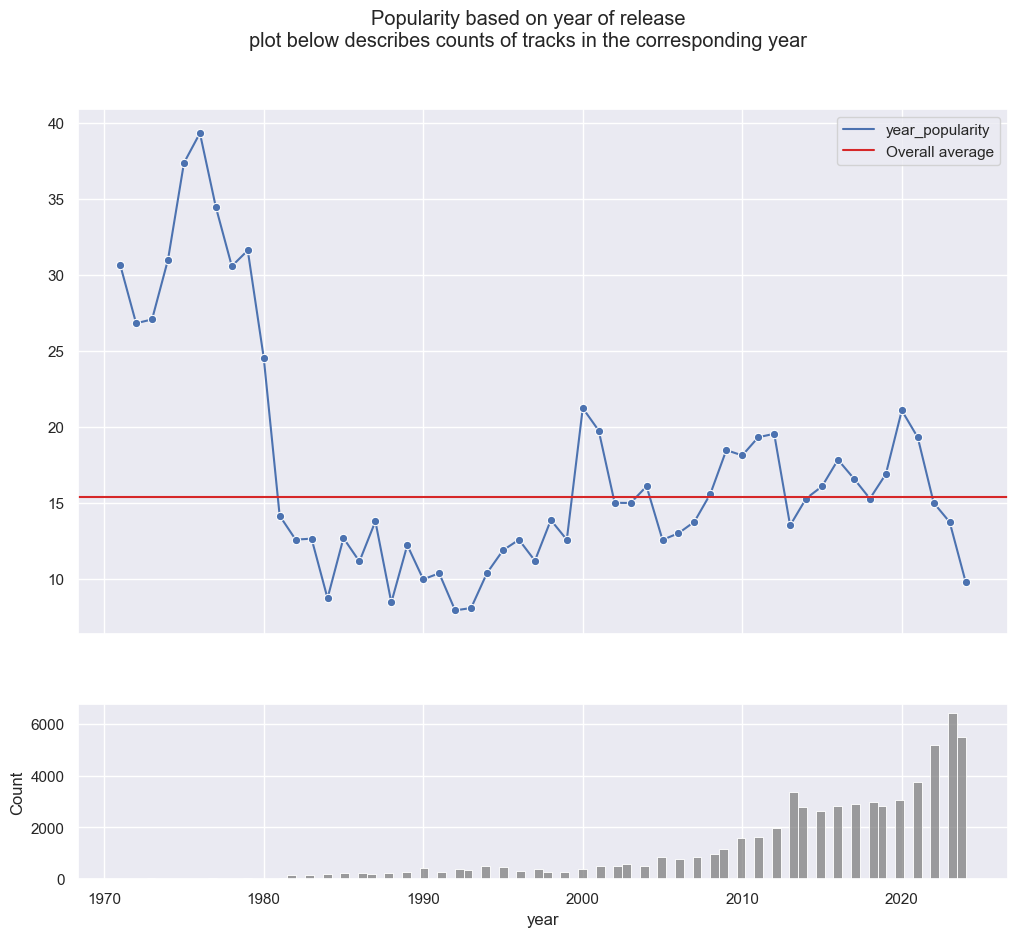

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

sns.lineplot(data=popularity_by_year, ax=ax[0], marker='o')
sns.histplot(data=data, x='year', color='grey')

ax[0].axhline(y=data['popularity'].mean(), color='tab:red', label='Overall average')

ax[0].legend()

fig.suptitle('Popularity based on year of release\nplot below describes counts of tracks in the corresponding year')

c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\samue\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


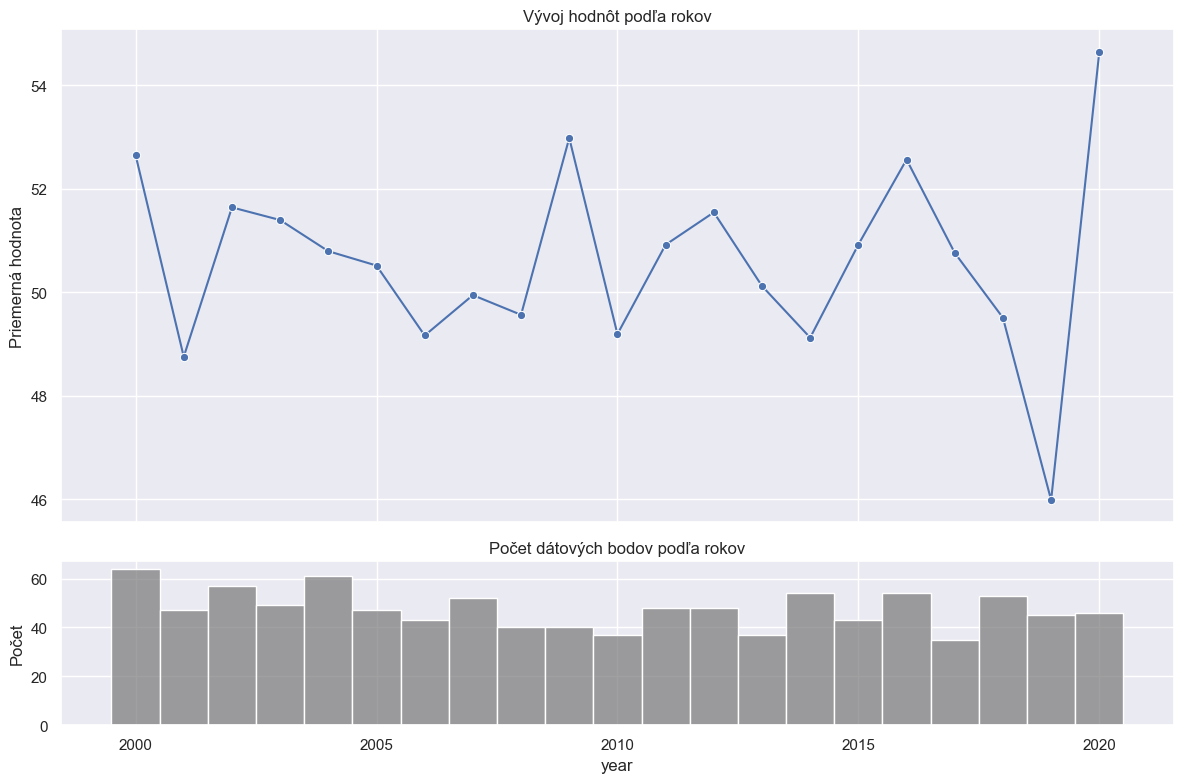

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Simulácia dát
np.random.seed(42)
years = np.random.choice(range(2000, 2021), size=1000)
values = np.random.normal(loc=50, scale=10, size=1000)
df = pd.DataFrame({'year': years, 'value': values})

# Agregácia pre linechart
line_data = df.groupby('year')['value'].mean().reset_index()

# Vytvorenie subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Linechart na hornom grafe
sns.lineplot(data=line_data, x='year', y='value', ax=ax[0], marker='o')
ax[0].set_title('Vývoj hodnôt podľa rokov')
ax[0].set_ylabel('Priemerná hodnota')
ax[0].grid(True)

# Histogram (countplot) na dolnom grafe
sns.histplot(data=df, x='year', bins=len(df['year'].unique()), ax=ax[1], discrete=True, color='gray')
ax[1].set_title('Počet dátových bodov podľa rokov')
ax[1].set_ylabel('Počet')
ax[1].grid(True)

# Upraviť layout
plt.tight_layout()
plt.show()


Although not uniform, language distribution is roughly balanced with english not having overwhelming majority.

<Axes: xlabel='language'>

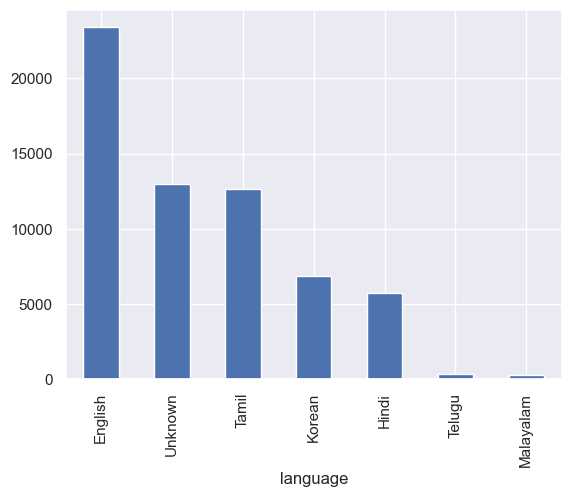

In [18]:
data['language'].value_counts().plot.bar()